Check `md5`, `sha1` and record `file magic type`, `runnable` as well.

### File hash functions
- https://stackoverflow.com/questions/22058048/hashing-a-file-in-python
- https://stackoverflow.com/questions/3431825/generating-an-md5-checksum-of-a-file

In [4]:
import hashlib

filePath = '../惡意程式樣本與清冊/202207_malware_sample/20227_1_Xorddos/0aefb67c01a24d05351b093455203fa2.bin'

In [6]:
def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

md5(filePath)

'0aefb67c01a24d05351b093455203fa2'

In [26]:
def sha256(fname):
    hash = hashlib.sha256()
    with open(fname, "rb") as f:
        bytes = f.read() # read entire file as bytes
        readable_hash = hashlib.sha256(bytes).hexdigest()
    return readable_hash
    #     for chunk in iter(lambda: f.read(4096), b""):
    #         hash.update(chunk)
    # return hash.hexdigest()

sha256(filePath)

'53af22acf7acd1a1e5bea6b4a85908611addb852dee24ccb6545df10738d8858'

### Magic type function
- https://stackoverflow.com/questions/1974724/is-there-a-python-equivalent-of-the-unix-file-utility
- https://github.com/Yelp/elastalert/issues/1927

In [8]:
! pip install python-magic-bin==0.4.14

     -------------------------------------- 409.3/409.3 kB 1.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import magic
def getMagic(fname):
    return magic.from_buffer(open(fname, "rb").read(2048))

getMagic(filePath)

'ELF 32-bit LSB executable, Intel 80386, version 1 (SYSV)'

### Collecting information

In [37]:
import glob
import os
rootFolder = "../惡意程式樣本與清冊/202207_malware_sample"
sampleRootFolder = glob.glob(os.path.join(rootFolder, "*")) # [x[0] for x in os.walk(rootFolder)] # same as
print(sampleRootFolder)

data_list = []
for familyFolder in sampleRootFolder:
    sampleFiles = glob.glob(os.path.join(familyFolder, "*"))
    # file is full filepath
    for file in sampleFiles:
        data = {}
        data['family'] = familyFolder.split('_')[-1]
        data['filename'] = file.split('\\')[-1]
        data['md5'] = md5(file)
        data['sha256'] = sha256(file)
        m = getMagic(file)
        data['magic'] = m
        if m.find('ARM') != -1:
            data['platform'] = 'ARM'
        elif m.find('MIPS') != -1:
            data['platform'] = 'MIPS'
        elif m.find('Intel') != -1:
            data['platform'] = 'X86'
        elif m.find('64-bit') != -1:
            data['platform'] = 'X86_64'
        else:
            data['platform'] = 'none' # not executable
        data_list.append(data)
print('num of samples:', len(data_list))

['../惡意程式樣本與清冊/202207_malware_sample\\20227_1_Xorddos', '../惡意程式樣本與清冊/202207_malware_sample\\20227_2_Mozi', '../惡意程式樣本與清冊/202207_malware_sample\\20227_3_Mirai', '../惡意程式樣本與清冊/202207_malware_sample\\20227_4_Dofloo', '../惡意程式樣本與清冊/202207_malware_sample\\20227_5_Tsunami']
num of samples: 63


In [38]:
import pandas as pd
df = pd.DataFrame(data=data_list)
df.to_csv('sample_info.csv', index=False)

In [40]:
df.head(2)

,family,filename,md5,sha256,magic,platform
0,Xorddos,07c070b717a23453a2b71c7582d6a928.bin,07c070b717a23453a2b71c7582d6a928,41ca9938f558d4e2441cd2463fb5152d72b81b1ac1f213...,"ELF 32-bit LSB executable, Intel 80386, versio...",X86
1,Xorddos,0aefb67c01a24d05351b093455203fa2.bin,0aefb67c01a24d05351b093455203fa2,53af22acf7acd1a1e5bea6b4a85908611addb852dee24c...,"ELF 32-bit LSB executable, Intel 80386, versio...",X86


### 分析結果
1. 惡意程式能否執行? 只有 X86, X86_64, ARM 能被執行，MIPS 與其餘皆無法。注意即使能順利執行，也不保證不被 kill by singal。

ref: https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

[Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '7'),
 Text(0, 0, '12'),
 Text(0, 0, '37')]

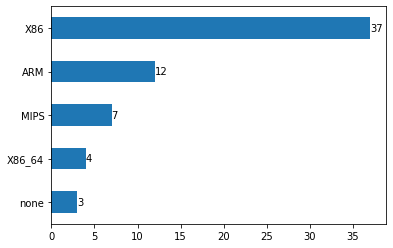

In [45]:
# df['platform']
ax = df.platform.value_counts().sort_values().plot(kind = 'barh')
ax.bar_label(ax.containers[0])

In [71]:
print(df.family.unique())

chart_data = {'executable':[], 'non-executable':[]}
for family in df.family.unique():
    f_df = df[df.family == family]
    executable_cnt = len(f_df[f_df.platform.isin(['X86_64','X86','ARM'])])
    non_executable_cnt = len(f_df[~f_df.platform.isin(['X86_64','X86','ARM'])])
    chart_data['executable'].append(executable_cnt)
    chart_data['non-executable'].append(non_executable_cnt)
    # non_executable_cnt = f_df[f_df.platform in ['MIPS','none']]
chart_data

['Xorddos' 'Mozi' 'Mirai' 'Dofloo' 'Tsunami']


{'executable': [21, 6, 7, 15, 4], 'non-executable': [0, 4, 0, 3, 3]}

In [72]:
pd.DataFrame(chart_data, index=df.family.unique())

,executable,non-executable
Xorddos,21,0
Mozi,6,4
Mirai,7,0
Dofloo,15,3
Tsunami,4,3


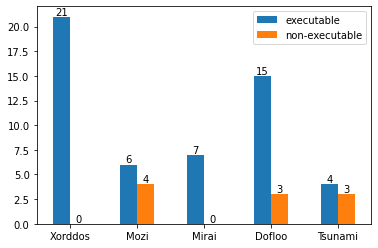

In [73]:
ax = pd.DataFrame(chart_data, index=df.family.unique()).plot.bar(rot=0)
for container in ax.containers:
    ax.bar_label(container)

2. hash值使否與檔名吻合? Ans: 通通吻合。

In [77]:
df.columns

Index(['family', 'filename', 'md5', 'sha256', 'magic', 'platform'], dtype='object')

In [81]:
for idx, row in df.iterrows():
    try:
        fname = row.filename.split('.')[0]
    except:
        fname = row.filename
    if fname not in [row.md5, row.sha256]:
        print(row.filename)